In [1]:
# from cvxopt  import solvers, matrix
import numpy as np
from qpsolvers import solve_qp
from numpy import array, dot
import sympy as sym
import math 

thrd = 2

class spline5:
    def __init__(self, Xseq, Yseq, yaw=None, Tseq=None, vx=None, vy=None):
        self.Xseq = Xseq
        self.Yseq = Yseq
        self.vx = vx 
        self.vy = vy 
        self.Tseq = Tseq if Tseq is not None else range(len(Xseq))
        
        self.T = 80
        order = 6
        self.order = order
        
        if len(self.Tseq) == 1:
            return
        
        p = np.zeros([len(self.Tseq) * 2, (order + 1) * 2])
        q = np.zeros([len(self.Tseq) * 2, 1])
        for i in range(len(self.Tseq)):
            t = self.Tseq[i] / (self.T - 1)
            for j in range(order + 1):
                ttt = np.power(t, j)
                p[i][j] = ttt
                p[i + len(self.Tseq)][j + order + 1] = ttt
            q[i] = Xseq[i]
            q[i + len(self.Tseq)] = Yseq[i]

            
            
        bound = 2
###### -b <= d2y/d2x <= b
        g = np.zeros([len(self.Tseq) * 2, (order + 1) * 2])
        h = np.zeros([len(self.Tseq) * 2])
        for i in range(len(self.Tseq)):
            t = self.Tseq[i] / (self.T - 1)
            
            for j in range(2, order + 1):
                ttt = np.power(t, j-2)
                g[i][j]                 = -bound * j * (j-1) * ttt
                g[i][j + order + 1]     = j * (j-1) * ttt            
                
                g[i + len(self.Tseq)][j]        = -bound * j * (j-1) * ttt
                g[i + len(self.Tseq)][j + order + 1] = -j * (j-1) * ttt
        

####### -b <= d2x/d2y <= b
        g2 = np.zeros([len(self.Tseq) * 2, (order + 1) * 2])
        h2 = np.zeros([len(self.Tseq) * 2])
        for i in range(len(self.Tseq)):
            t = self.Tseq[i] / (self.T - 1)
            
            for j in range(2, order + 1):
                ttt = np.power(t, j-2)
                g2[i][j]                      = j * (j-1) * ttt            
                g2[i][j + order + 1]          = -bound * j * (j-1) * ttt
                
                g2[i + len(self.Tseq)][j]             = -j * (j-1) * ttt
                g2[i + len(self.Tseq)][j + order + 1] = -bound * j * (j-1) * ttt
        

####### 
        


        
#         np.set_printoptions(precision=2)
#         print('p', p)
#         P = np.dot(p.T, p) + np.dot(g.T, g) * 0.001 + np.eye((order + 1) * 2) * 0.0001
        P = np.dot(p.T, p) + np.eye((order + 1) * 2) * 0.0001
        Q = -np.dot(q.T, p)
            
        Q = Q.reshape(((order + 1) * 2,))
        
        A = np.zeros([5, (order + 1) * 2])
        B = np.zeros([A.shape[0], 1])
        
        A[0][0] = 1
        A[1][order + 1] = 1
        B[0] = Xseq[0]
        B[1] = Yseq[0]
        
        if vx is not None and vy is not None:
            A[2][1] = 1
            B[2] = vx 
            A[3][1 + order + 1] = 1
            B[3] = vy 
            
        if yaw is not None:
            A[-1][1] = math.tan(yaw) 
            A[-1][1+order+1] = -1

            B[-1] = 0
            
        B = B.reshape((A.shape[0],))
        
        
        G = np.concatenate([g, g2])
        H = np.concatenate([h, h2])
                
#         self.sol = solve_qp(P=P, q=Q)
        self.sol = solve_qp(P=P, q=Q, A=A, b=B)
#         self.sol = solve_qp(P=P, q=Q, A=A, b=B, G=G, h=H)



    def cal(self, t):
        if len(self.Tseq) == 1:
            return self.Xseq[0], self.Yseq[0], 0, 0
            
        x = 0
        y = 0
        order = self.order
        dx = 0
        dy = 0
        
        if t >= 0 and t <= 1:
            for i in range(order + 1):
                ttt = np.power(t, i)
                x += self.sol[i] * ttt
                y += self.sol[i + order + 1] * ttt

            for i in range(1, order + 1):    
                ttt = np.power(t, i - 1)
                dx += self.sol[i] * i * ttt
                dy += self.sol[i + order + 1] * i * ttt
        
        return x, y, dx, dy 

    def plot_scatter(self):
        X, Y = [], []

        T = [i / (self.T - 1) for i in range(self.T)]
        for t in T:
            x, y, dx, dy = self.cal(t)
            X.append(x)
            Y.append(y)

            
        plt.scatter(T, X)
        plt.scatter([ts / (self.T - 1) for ts in (self.Tseq)], self.Xseq, color='red')
        plt.show()        
#     
        plt.scatter(T, Y)
        plt.scatter([ts / (self.T - 1) for ts in (self.Tseq)], self.Yseq, color='red')
        plt.show()

        plt.scatter(X, Y)
        plt.scatter(self.Xseq, self.Yseq, color='red')
        plt.show()

# sp = spline5(Xseq[::1], Yseq[::1])
# sp = spline5(Xseq=traj_interval_vel[:, 0], 
#                      Yseq=traj_interval_vel[:, 1],
#                      vx=np.cos(traj_interval_vel[:,2]) * traj_interval_vel[:,3] / 10, 
#                      vy=np.sin(traj_interval_vel[:,2]) * traj_interval_vel[:,3] / 10)
# sp.cal(0)

def traj_plot(traj, rot, orig, ax=None, c="", s=[]):

    
    if isinstance(traj, torch.Tensor):
        traj = traj.numpy()
    rot = rot.numpy()
    orig = orig.numpy()
    
    centerline = np.array([traj[:, 0] - orig[0], traj[:, 1] - orig[1]]).T
#     print(centerline)
    centerline = np.matmul(rot, (centerline.reshape(-1, 2)).T).T

    if ax is not None:
        ax.plot(centerline[:, 0], centerline[:, 1], c, s)
        
    return centerline

def dis(x0, x1, y0, y1):
    return np.sqrt((x0-x1)**2 + (y0-y1)**2)


In [2]:
def traj_diff(tr1, tr2):
    L = min(tr1.shape[0], tr2.shape[0])
    ade  = np.sqrt(np.sum((tr1[:L, :2] - tr2[:L, :2]) ** 2, axis=1)).sum() / L
    return ade

def traj_rmse(tr1, tr2):
    L = min(tr1.shape[0], tr2.shape[0])
    rmse = np.sqrt(np.sum((tr1[:L, :2] - tr2[:L, :2]) ** 2) / L)  
    return rmse

def interval(data, results, idx, a, k):
    pred_traj = np.insert(results[idx][a, k, :, :], 2, values=None, axis=1)
    gt_hist = data['gt_hist'][idx][a].cpu().detach().numpy()
    traj_origin = np.concatenate([gt_hist, pred_traj])
    return interval_traj(traj_origin)

def interval_traj(traj_origin):
    # 起点
    traj_origin = traj_origin.copy()
    traj_interval = [traj_origin[0]]
    velo_interval = [dis(traj_origin[1][0], traj_origin[0][0], traj_origin[1][1], traj_origin[0][1]) * 10]
    
#     Tseq = [0]
    for i in range(1, traj_origin.shape[0] - 1):
        if dis(traj_origin[i][0], traj_interval[-1][0], traj_origin[i][1], traj_interval[-1][1]) >= thrd:
            traj_origin[i][2] = np.arctan2(traj_origin[i][1] - traj_interval[-1][1], traj_origin[i][0] - traj_interval[-1][0])
            traj_interval.append(traj_origin[i])
            vel = dis(traj_origin[i + 1][0], traj_origin[i - 1][0], traj_origin[i + 1][1], traj_origin[i - 1][1]) * 5
            velo_interval.append(vel)
        else:
            traj_origin[i][2] = traj_origin[i - 1][2]
            
                         
    # 终点
    traj_origin[-1][2] = np.arctan2(traj_origin[-1][1] - traj_interval[-1][1], traj_origin[-1][0] - traj_interval[-1][0])
    traj_interval.append(traj_origin[-1])
    vel = dis(traj_origin[-1][0], traj_origin[-2][0], traj_origin[-1][1], traj_origin[-2][1]) * 10
    velo_interval.append(vel)
#     Tseq[-1] = traj_origin.shape[0] - 1

    traj_interval_vel = np.concatenate([np.array(traj_interval), np.expand_dims(np.array(velo_interval), axis=1)], axis=1)
    
    
    gt_hist = traj_origin[:20]
    pred_traj = traj_origin[20:]
    X, Y, Yaw, VX, VY = [], [], [], [], []
    for t in range(20):
        X.append(gt_hist[t][0])
        Y.append(gt_hist[t][1])        
        Yaw.append(gt_hist[t][2])
        if t == 0:
            vx = gt_hist[1][0] - gt_hist[0][0]
            vy = gt_hist[1][1] - gt_hist[0][1]
        else:
            vx = gt_hist[t][0] - gt_hist[t-1][0]
            vy = gt_hist[t][1] - gt_hist[t-1][1]
        VX.append(vx * 10)
        VY.append(vy * 10)
    

    Tseq = [0]
    for t in [20,40,60,79]:
        if dis(pred_traj[t, 0], pred_traj[Tseq[-1], 0], pred_traj[t, 0], pred_traj[Tseq[-1], 1]) >= 0.1:
            Tseq.append(t)
            
    sp = spline5(Xseq=pred_traj[Tseq, 0], 
                 Yseq=pred_traj[Tseq, 1],
                 Tseq=Tseq,
#                  yaw =gt_hist[-1, 2],
                 vx=VX[-1] * 8,
                 vy=VY[-1] * 8)

    lastx, lasty = gt_hist[19][0], gt_hist[19][1]
    for t in range(80):
        x, y, dx, dy = sp.cal(t/79)
        X.append(x)
        Y.append(y)
        VX.append(dx / 8)
        VY.append(dy / 8)
        lastx, lasty = x, y        
        Yaw.append(math.atan2(VY[-1], VX[-1]))

    traj_to_show = np.concatenate([np.array(X).reshape(-1, 1), 
                                   np.array(Y).reshape(-1, 1),
                                   np.array(Yaw).reshape(-1, 1),
                                   np.array(VX).reshape(-1, 1),
                                   np.array(VY).reshape(-1, 1)], axis=1)
    
    return traj_to_show, traj_interval_vel
        
# traj_to_show, traj_interval_vel = interval(data, results, idx, 2, 0)
# plt.plot(np.sqrt(traj_to_show[:, 3]**2 + traj_to_show[:, 4] ** 2))
# traj_to_show

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes
# from matplotlib.patches import Polygon,Circle
from matplotlib.collections import PatchCollection


def rect_plot(pos, rot, orig, w, l, ax, c):
    rot = rot.numpy()
    orig = orig.numpy()    

    ax.plot(centerline[:, 0], centerline[:, 1], c)
    return centerline

def polygon_xy_from_motionstate(ms, width, length):
    lowleft = (ms[0] - length / 2., ms[1] - width / 2.)
    lowright = (ms[0] + length / 2., ms[1] - width / 2.)
    upright = (ms[0] + length / 2., ms[1] + width / 2.)
    upleft = (ms[0] - length / 2., ms[1] + width / 2.)
    return rotate_around_center(np.array([lowleft, lowright, upright, upleft]), np.array([ms[0], ms[1]]), yaw=ms[2])

def rotate_around_center(pts, center, yaw):
    return np.dot(pts - center, np.array([[np.cos(yaw), np.sin(yaw)], [-np.sin(yaw), np.cos(yaw)]])) + center

def yaw_diff(cur_yaw, last_yaw):
    yaw_diff = cur_yaw - last_yaw
    if yaw_diff > 3.14:
        yaw_diff = 6.28 - yaw_diff
    elif yaw_diff < -3.14:
        yaw_diff = 6.28 + yaw_diff
        
    return yaw_diff


In [4]:
def KL(gt, pred):
    
    tmp_N = 40
    prob_gt = np.zeros(tmp_N + 1)
    prob_pred = np.zeros(tmp_N + 1)
    
    upper = max(max(gt), max(pred))
    lower = min(min(gt), min(pred))
#     print(upper, lower)

    itv = (upper - lower) / tmp_N

    for beta in gt:
        prob_gt[int((beta - lower) // itv)] += 1
    prob_gt /= sum(prob_gt)
#     np.set_printoptions(precision = 8)
#     print("prob_gt", np.around(prob_gt, 3))
    
    for beta in pred:
        prob_pred[int((beta - lower) // itv)] += 1 
    prob_pred /= sum(prob_pred)
#     print("prob_pred", np.around(prob_pred, 3))
    
    res = 0
    for i in range(tmp_N):
#         if prob_gt[i] > 10e-16:
        res += prob_pred[i] * np.log((prob_pred[i] + 1e-6) / (prob_gt[i] + 1e-6))
    return res

# KL(gt_all_beta_rcd, all_beta_rcd)
# print(max(gt_all_beta_rcd), min(gt_all_beta_rcd))

In [5]:
import argparse
import os
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import InteDataset
from data import ArgoTestDataset
from utils import Logger, load_pretrain
from shapely.geometry import Polygon

import numpy as np
import scipy

# define parser
parser = argparse.ArgumentParser(description="Argoverse Motion Forecasting in Pytorch")
parser.add_argument(
    "-m", "--model", default="lanegcn", type=str, metavar="MODEL", help="model name"
)
parser.add_argument("--eval", action="store_true", default=True)
parser.add_argument(
    "--split", type=str, default="val", help='data split, "val" or "test"'
)
parser.add_argument(
    "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
)
# parser.add_argument(
#     "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
# )


_StoreAction(option_strings=['--weight'], dest='weight', nargs=None, const=None, default='/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt', type=<class 'str'>, choices=None, help='checkpoint path', metavar='WEIGHT')

In [6]:
root_path = '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified'
sys.path.insert(0, root_path)

model = import_module("lanegcn")
config, _, collate_fn, net, loss, post_process, opt = model.get_model()


In [7]:
config

{'display_iters': 79872,
 'val_iters': 79872,
 'save_freq': 0.1,
 'epoch': 0,
 'horovod': True,
 'opt': 'adam',
 'num_epochs': 80,
 'lr': [0.001, 0.0001],
 'lr_epochs': [32],
 'lr_func': <utils.StepLR at 0x7fa7c1de3210>,
 'save_dir': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/results/lanegcn',
 'batch_size': 16,
 'val_batch_size': 16,
 'workers': 0,
 'val_workers': 0,
 'train_split': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/train/data',
 'val_split': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/val/data',
 'test_split': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/test_obs/data',
 'preprocess': True,
 'preprocess_train': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/preprocess/val_crs_dist6_angle90.p',
 'preprocess_val': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/preprocess/val_crs_dist6_angle90.p',
 'preprocess_test': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/prepro

In [8]:
## 10s multi LL
# ckpt_path = "/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_training_EEMG/results_multi_ll/80.000.ckpt"
# ckpt_path = "/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified_2022/results/10sMultiLL/80.008.ckpt"

## 10s single LL
# ckpt_path = "/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_training_EEMG/results_0812/41.000.ckpt"

## 10s GCN
ckpt_path = "/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/results/10sGCN/47.000.ckpt"

## 5s multi LL
# ckpt_path = "/home/user/Projects/interaction_gyt/preprocess_results_5s_for_training_EEGM/results/11.000.ckpt"


if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()

with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0914", 'EP0_all_940_1070_950_1040_mask.pkl'), 'rb') as f:
    img_EP0 = pickle.load(f, encoding="latin1")
    EP0_bds = (940, 1070, 950, 1040)
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0914", 'EP1_all_942_1115_949_1032_mask.pkl'), 'rb') as f:
    img_EP1 = pickle.load(f, encoding="latin1")
    EP1_bds = (942, 1115, 949, 1032)
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0914", 'GL_all_920_1040_940_1025_mask.pkl'), 'rb') as f:
    img_GL = pickle.load(f, encoding="latin1")
    GL_bds = (920, 1040, 940, 1025)
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0914", 'MA_all_970_1080_960_1050_mask.pkl'), 'rb') as f:
    img_MA = pickle.load(f, encoding="latin1")
    MA_bds = (970, 1080, 960, 1050)

#TrajGen
# testing_record = np.load("/home/user/Backup/DRL服务器备份/Logs/1203/testing_record.npy", allow_pickle=True).item() 

#GAIL
# testing_record_filename = "/home/user/Backup/DRL服务器备份/Logs/1216/testing_record.npy"

#大修
# testing_record = np.load("/home/user/Backup/DRL服务器备份/Logs/1717/testing_record.npy", allow_pickle=True).item() #TrajGen
# testing_record = np.load("/home/user/Backup/DRL服务器备份/Logs/1719/testing_record_FT.npy", allow_pickle=True).item() #TrajGen
# testing_record = np.load("/home/user/Backup/DRL服务器备份/Logs/1719/testing_record_SR.npy", allow_pickle=True).item() #TrajGen
# testing_record = np.load("/home/user/Backup/DRL服务器备份/Logs/1719/testing_record_td3.npy", allow_pickle=True).item() #TrajGen
# testing_record = np.load("/home/user/Backup/DRL服务器备份/Logs/1801/testing_record.npy", allow_pickle=True).item() #TD3
testing_record_filename = "/home/user/Backup/DRL服务器备份/Logs/1806/testing_record_SR.npy"
# testing_record_filename = "/home/user/Backup/DRL服务器备份/Logs/1806/testing_record_TD3.npy"
# testing_record_filename = "/home/user/Backup/DRL服务器备份/Logs/1806/testing_record_attention.npy"
# testing_record_filename = "/home/user/Backup/DRL服务器备份/Logs/1806/testing_record_TD3.npy"
# testing_record_filename = "/home/user/Backup/DRL服务器备份/Logs/0913/testing_record_0913_2.npy"



# testing_record = np.load("/home/user/Backup/DRL服务器备份/Logs/1726/testing_record.npy", allow_pickle=True).item() #TrajGen

testing_record = np.load(testing_record_filename, allow_pickle=True).item()


In [ ]:
# min_x

In [339]:
np.array(origin_data['gt_xyphi']).shape
origin_data['shapes'].shape[0]

2

In [340]:
###### 10s csv
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_use_csv_EP0_with_agtid_final/test'

###### 10s densetnt csv
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_densetnt_origin10s_10scsv/test/'

## 10s 泛
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_FT/test'
filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_SR_xyphi/test'
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_testing_fake_FT/test'
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_testing_fake_SR/test'
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_testing_fake_EP0/test'


## 10s test
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_testing_EP0/test/'

## 5s test
## filepath = '/home/user/Projects/interaction_gyt/preprocess_results_5s_for_training_EEGM/test/'

# 10 EEMG
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_10s_for_testing_EEMG/test'


dataset = InteDataset(filepath)
# dataset = InteDataset('/home/user/Datasets/raw_map/preprocess_results_5s/tmp/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=False,
)

# begin inference
preds = {}
gts = {}
cities = {}

data_list = []
off_road_count = 0
total_count = 0
ASD_sum, FSD_sum = 0, 0
k = 0

max_acc_rcd, min_acc_rcd = [], []
all_beta_rcd, max_beta_rcd = [], []

use_ground_truth = True #首次启动为True
use_raw_pred = False #默认False

MASD = 0
RMSE = 0

for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        
        output = net(data)
        loss_out = loss(output, data)
        results = [x.detach().cpu().numpy() for x in output["reg"]]

        for idx in range(len(results)):

            filename = data['filename'][idx].split('/')[-1]
            with open(os.path.join(filepath, filename), 'rb') as f:
                origin_data = pickle.load(f, encoding="latin1")

            if filename[-6:-4] == "P0":
                use_img = img_EP0
                min_x, max_x, min_y, max_y = EP0_bds
            elif filename[-6:-4] == "P1":
                use_img = img_EP1    
                min_x, max_x, min_y, max_y = EP1_bds
            elif filename[-6:-4] == "GL":
                use_img = img_GL
                min_x, max_x, min_y, max_y = GL_bds
            else:
                use_img = img_MA
                min_x, max_x, min_y, max_y = MA_bds
            
            masd_a = 0
            
#             if filename not in testing_record:
#                 continue
#             for other_id in testing_record[filename]:
            for a in range(origin_data['shapes'].shape[0]):
                other_id = origin_data['agt_ids'][a]
                
#                 #####
#                 if filename not in testing_record or other_id not in testing_record[filename]:
#                     continue
                    
#                 #####
                
                print("agent ", other_id)

                in_road_trajectories = []
                ASDs, FSDs = [], []
#                 traj_RL = None
                
                for k in range(6):
                    traj_xyphi, traj_interval_vel = interval(data, results, idx, a, k)
#                     if traj_RL is not None:
#                         ASDs.append(traj_diff(traj_RL, traj_xyphi))
#                         FSDs.append(np.sqrt(((traj_RL[-1][:2] - traj_xyphi[-1][:2]) ** 2).sum()))
                    
#                     if k == 0 and filename in testing_record and other_id in testing_record[filename]:
#                         rearidx = [0,1,4,2,3]
#                         traj_xyphi = np.array(testing_record[filename][other_id]['trajectory'])[:,rearidx]
#                         print("  RL:", traj_xyphi.shape[0])
                    
                    
                    if k == 0:
#                         gt_traj = np.concatenate([origin_data['gt_hist'][a][:,:2], origin_data['gt_preds'][a]])
                        gt_traj = np.array(origin_data['gt_xyphi'][a])
    
                        max_acc = float('-inf')
                        min_acc = float('inf')
                        max_beta = 0
                        for ttt in range(gt_traj.shape[0]):
                            if ttt > 1:
                                if use_ground_truth:
                                    x, y = gt_traj[ttt][:2]
                                    dx0, dy0 = gt_traj[ttt][0] - gt_traj[ttt-1][0], gt_traj[ttt][1] - gt_traj[ttt-1][1]
                                    cur_v = np.sqrt(dx0 ** 2 + dy0 ** 2) * 10
#                                     cur_yaw = math.atan2(dy0, dx0)
                                    cur_yaw = gt_traj[ttt][2]

                                    dx1, dy1 = gt_traj[ttt-1][0] - gt_traj[ttt-2][0], gt_traj[ttt-1][1] - gt_traj[ttt-2][1]
                                    last_v = np.sqrt(dx1 ** 2 + dy1 ** 2) * 10
#                                     last_yaw = math.atan2(dy1, dx1)
                                    last_yaw = gt_traj[ttt-1][2]
                                    
                                elif use_raw_pred:    
                                    res_traj = np.concatenate([origin_data['gt_hist'][a][:,:2], results[idx][a][k]])
                                    traj_xyphi = res_traj
                                    x, y = traj_xyphi[ttt][:2]
                                    
                                    dx0, dy0 = res_traj[ttt][0] - res_traj[ttt-1][0], res_traj[ttt][1] - res_traj[ttt-1][1]
                                    cur_v = np.sqrt(dx0 ** 2 + dy0 ** 2) * 10
                                    cur_yaw = math.atan2(dy0, dx0)

                                    dx1, dy1 = res_traj[ttt-1][0] - res_traj[ttt-2][0], res_traj[ttt-1][1] - res_traj[ttt-2][1]
                                    last_v = np.sqrt(dx1 ** 2 + dy1 ** 2) * 10
                                    last_yaw = math.atan2(dy1, dx1)
                                    
                                else:
                                    x, y = traj_xyphi[ttt][:2]
                                    cur_v = np.sqrt(traj_xyphi[ttt][3] ** 2 + traj_xyphi[ttt][4] ** 2)
                                    last_v = np.sqrt(traj_xyphi[ttt-1][3] ** 2 + traj_xyphi[ttt-1][4] ** 2)                            
                                    cur_yaw = traj_xyphi[ttt][2]
                                    last_yaw = traj_xyphi[ttt-1][2]

#                                 # 正常行驶至道路末端
                                if x < min_x or x > max_x or y < min_y or y > max_y:
                                    continue
                                    
                                beta = min((cur_yaw - last_yaw) % 6.28, (last_yaw - cur_yaw) % 6.28)
                                all_beta_rcd.append(beta)
                                max_beta = max(max_beta, beta)

                                acc = (cur_v - last_v) * 10
                                max_acc = max(max_acc, acc)
                                min_acc = min(min_acc, acc)
                                
                        max_beta_rcd.append(max_beta)
                        max_acc_rcd.append(max_acc)
                        min_acc_rcd.append(min_acc)
                        
                        if max_acc > 4.0 or min_acc < -4.0:
                            print(max_acc, min_acc, "><4.0", filename, other_id)
                            
                        
                        RMSE += traj_rmse(traj_xyphi, gt_traj)
                    
                    
                    flag_off_road = False
                    for ttt in range(traj_xyphi.shape[0]):
                        x, y = traj_xyphi[ttt][:2]

                        # 正常行驶至道路末端
                        if x < min_x or x > max_x or y < min_y or y > max_y:
                            continue
            
                        grid_x, grid_y = int((x - min_x) / (max_x - min_x + 1) * use_img.shape[1]), int((max_y - y) / (max_y - min_y + 1) * use_img.shape[0])
                        if use_img[grid_y, grid_x] != 0:
#                             print("tag from %s agt %d fail at time %d, pos %f, %f, value %d" %(tag, a, ttt, x, y, use_img[grid_y, grid_x]))
                            flag_off_road = True
                                        
                    if flag_off_road:
                        off_road_count += 1
#                         continue
                    
                    in_road_trajectories.append(traj_xyphi)
                        
                Kv = len(in_road_trajectories)
                max_D = 0
                for k1 in range(Kv):
                    for k2 in range(k1 + 1, Kv):
                        D = traj_diff(in_road_trajectories[k1], in_road_trajectories[k2])
                        max_D = max(D, max_D)
                        
                        ASDs.append(D)
                        FSDs.append(np.sqrt(((in_road_trajectories[k1][-1][:2] - in_road_trajectories[k2][-1][:2]) ** 2).sum()))

                total_count += 1
                if len(ASDs) > 0:

                    MASD += max_D

                    ASD_sum += min(ASDs)
                    FSD_sum += min(FSDs)
                    print("    among", Kv, "trajs, max_D", max_D, "    asd ", min(ASDs), " fsd ", min(FSDs))
    
if use_ground_truth:
    gt_all_beta_rcd = all_beta_rcd
    gt_all_beta_rcd = all_beta_rcd
    gt_max_beta_rcd = max_beta_rcd
    gt_max_acc_rcd = max_acc_rcd
    gt_min_acc_rcd = min_acc_rcd
    print("This is ground truth:")
                
print("RMSE:", RMSE / total_count)
print("MASD:", MASD / total_count)
print("Wass-Dis between gt:", scipy.stats.wasserstein_distance(gt_all_beta_rcd, all_beta_rcd))
print("My KL:", KL(gt_all_beta_rcd, all_beta_rcd))
print("ASD:", ASD_sum / total_count)
print("FSD:", FSD_sum / total_count)

0it [00:00, ?it/s]

agent  65
    among 6 trajs, max_D 11.01166876806083     asd  1.1820531765528386  fsd  7.529863550824758
agent  61
    among 6 trajs, max_D 5.2684223355593165     asd  1.0471688640356929  fsd  5.0214733627463115
agent  68
    among 6 trajs, max_D 8.563695038802377     asd  2.1740599205306874  fsd  7.957556885006456
agent  69
    among 6 trajs, max_D 13.603104456294027     asd  1.1478904573637139  fsd  3.8298427964963464
agent  70
    among 6 trajs, max_D 4.63462162055288     asd  0.3880208444029896  fsd  1.844607389598078
agent  73
    among 6 trajs, max_D 12.214401199641     asd  1.0504493361048814  fsd  3.344851371313467
agent  74
    among 6 trajs, max_D 4.193394060615253     asd  0.30712364007561666  fsd  0.7752470071786407
agent  76
    among 6 trajs, max_D 22.448494607785946     asd  2.2459274562599627  fsd  8.104602200345695
agent  162
    among 6 trajs, max_D 4.0095916169946335     asd  0.43050125956495433  fsd  2.075720186612483
agent  125
    among 6 trajs, max_D 2.7379030697

    among 6 trajs, max_D 7.881478078587187     asd  1.1703064255379731  fsd  5.396823276402888
agent  161
    among 6 trajs, max_D 10.578089522810581     asd  1.370174234170053  fsd  5.129571568137475
agent  163
    among 6 trajs, max_D 9.140212308978864     asd  2.096664562576801  fsd  7.0272663291452595
agent  164
    among 6 trajs, max_D 6.216341673182223     asd  1.948243559306326  fsd  6.936447245563804
agent  23
    among 6 trajs, max_D 5.357703020669747     asd  0.18910543794314727  fsd  1.1275258711167615
agent  13
    among 6 trajs, max_D 8.610761767519653     asd  1.6231185860575261  fsd  5.405821976441852
agent  14
    among 6 trajs, max_D 4.843266873818544     asd  0.3049497271720106  fsd  1.857746817451202
agent  18
    among 6 trajs, max_D 7.288030417292821     asd  0.36300524921382404  fsd  2.1246492895191205
agent  20
    among 6 trajs, max_D 8.480546777155624     asd  1.0818368301011383  fsd  4.113873740099172
agent  21
    among 6 trajs, max_D 6.084431366036825     as

1it [00:07,  7.34s/it]

    among 6 trajs, max_D 4.276077463987072     asd  0.3817245570665932  fsd  2.1887099902191918
agent  5
    among 6 trajs, max_D 8.552236329083257     asd  0.5399181138697992  fsd  2.4565703364381704
agent  24
    among 6 trajs, max_D 5.844647902537112     asd  0.48399199515622116  fsd  1.8252141119775913
agent  27
    among 6 trajs, max_D 4.332007060206803     asd  0.37694782825185486  fsd  1.789765323575522
agent  28
    among 6 trajs, max_D 4.346850705518483     asd  0.7057622488755244  fsd  2.1099713477101414
agent  19
    among 6 trajs, max_D 11.05163468894636     asd  2.392121834179254  fsd  9.837078335022712
agent  3
    among 6 trajs, max_D 10.091067459153896     asd  2.113938893342388  fsd  9.147406047668321
agent  13
    among 6 trajs, max_D 5.0718994568805345     asd  0.2556029625742562  fsd  2.1670045127144357
agent  15
    among 6 trajs, max_D 10.178024256645243     asd  1.5596577224249077  fsd  6.301502782790015
agent  21
    among 6 trajs, max_D 6.57731204083433     asd

    among 6 trajs, max_D 3.2015130214000216     asd  0.1514561370690718  fsd  0.5644075885478459
agent  82
    among 6 trajs, max_D 7.395594917598893     asd  0.11925923224155544  fsd  0.9065535118693395
agent  83
    among 6 trajs, max_D 23.29845312830137     asd  2.340811678248096  fsd  7.430059381048542
agent  86
    among 6 trajs, max_D 10.78186935601421     asd  0.9800798913430709  fsd  4.998650636377616
agent  118
    among 6 trajs, max_D 11.024713765211757     asd  2.094782365450717  fsd  9.09157030596921
agent  71
    among 6 trajs, max_D 7.125335229489886     asd  1.1887099149012619  fsd  5.323356092024599
agent  67
    among 6 trajs, max_D 5.009469732922748     asd  1.0087656395111744  fsd  5.33353481337335
agent  68
    among 6 trajs, max_D 6.308795868829686     asd  0.4976048457450425  fsd  3.805910440374027
agent  69
    among 6 trajs, max_D 8.399434047450432     asd  1.7305207904128204  fsd  6.193167915208793
agent  72
    among 6 trajs, max_D 18.199687870009463     asd  

2it [00:14,  7.43s/it]

    among 6 trajs, max_D 9.685928753377302     asd  2.128402804764155  fsd  9.40495421753896
agent  76
    among 6 trajs, max_D 10.092261519175304     asd  1.2803218902801057  fsd  2.333501317317446
agent  35
    among 6 trajs, max_D 9.234022115565926     asd  1.8568227205548182  fsd  5.6104839737199255
agent  22
    among 6 trajs, max_D 7.240238718644929     asd  0.9502711724205719  fsd  3.2841970754703014
agent  26
    among 6 trajs, max_D 8.892167077996191     asd  0.9409089418174587  fsd  5.012018335847842
agent  28
    among 6 trajs, max_D 4.924621857285345     asd  0.9794561156559838  fsd  3.8849310233459273
agent  32
    among 6 trajs, max_D 14.908142698673064     asd  2.0516271804866326  fsd  8.11509335458478
agent  33
    among 6 trajs, max_D 9.717962128116726     asd  1.1624918661325245  fsd  5.834064333619818
agent  123
    among 6 trajs, max_D 10.883090393162615     asd  3.411206688699412  fsd  11.999986931019956
agent  78
    among 6 trajs, max_D 5.843249996803557     asd 

    among 6 trajs, max_D 6.22235069525125     asd  1.2815721571234417  fsd  5.412789928150506
agent  107
    among 6 trajs, max_D 11.786788661366286     asd  0.5843045312188232  fsd  1.9299726611950356
agent  115
    among 6 trajs, max_D 14.344910831915115     asd  2.1107828109117523  fsd  5.270518388488204
agent  116
    among 6 trajs, max_D 4.4658676954335155     asd  1.0338440428826032  fsd  5.621326872874973
agent  61
    among 6 trajs, max_D 6.086700716643893     asd  1.0714509219539257  fsd  5.567864113714337
agent  5
    among 6 trajs, max_D 4.4323171131248085     asd  0.7320230366927808  fsd  2.104379944275171
agent  15
    among 6 trajs, max_D 7.689770764863756     asd  0.3928408074770546  fsd  1.0065866180409226
agent  58
    among 6 trajs, max_D 6.123340721553433     asd  1.0869474381815132  fsd  4.769248617834696
agent  62
    among 6 trajs, max_D 5.47533918714918     asd  0.43581759753822197  fsd  1.8873309025335183
agent  65
    among 6 trajs, max_D 3.0868318350155732    

3it [00:21,  7.03s/it]

    among 6 trajs, max_D 1.448463578866436     asd  0.1764930082473515  fsd  0.5451877658769393
agent  68
    among 6 trajs, max_D 1.7182130970777552     asd  0.1175563840800765  fsd  0.20137849774766603
agent  71
    among 6 trajs, max_D 11.303185078150934     asd  1.1957511696923036  fsd  6.678306180941634
This is ground truth:
RMSE: 8.168124182233639
MASD: 7.505750454014541
Wass-Dis between gt: 0.0
My KL: 0.0
ASD: 0.8983704525209391
FSD: 3.6419461177349546


In [64]:
###### test lanegcn RMSE/ASD/FSD/。。。


###### 10s csv
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_use_csv_EP0_with_agtid_final/test'
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_EP0_xyphi/test/'

## 10s 泛
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_FT/test'
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_FT_xyphi/test'
filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_testing_fake_SR/test'


## 10s test
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_testing_EP0/test/'

## 5s test
## filepath = '/home/user/Projects/interaction_gyt/preprocess_results_5s_for_training_EEGM/test/'

# 10 EEMG
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_10s_for_testing_EEMG/test'
# 

# new_filepath = "/home/user/Backup/DRL服务器备份/Logs/1718/test_1718_SR/"
# new_filepath = "/home/user/Backup/DRL服务器备份/Logs/1815/routeloss_SRFT/SR_fake/"
new_filepath = "/home/user/Backup/DRL服务器备份/Logs/1801/test_Roundabout_fake/test_SR_fake/"

dataset = InteDataset(filepath)
# dataset = InteDataset('/home/user/Datasets/raw_map/preprocess_results_5s/tmp/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=False,
)

off_road_count = 0
total_count = 0
ASD_sum, FSD_sum = 0, 0

max_acc_rcd, min_acc_rcd = [], []
all_beta_rcd, max_beta_rcd = [], []
gt_all_beta_rcd = []

MASD = 0
RMSE = 0
rearidx = [0,1,4,2,3]

AF_acc, AF_beta, Col = 0, 0, 0
collision_trajs_count = 0
first_collision_trajs_count = 0

for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        
        output = net(data)
        loss_out = loss(output, data)
        results = [x.detach().cpu().numpy() for x in output["reg"]]

        for idx in range(len(results)):

            filename = data['filename'][idx].split('/')[-1]
            with open(os.path.join(filepath, filename), 'rb') as f:
                origin_data = pickle.load(f, encoding="latin1")

            if filename[-6:-4] == "P0":
                use_img = img_EP0
                min_x, max_x, min_y, max_y = EP0_bds
            elif filename[-6:-4] == "P1":
                use_img = img_EP1    
                min_x, max_x, min_y, max_y = EP1_bds
            elif filename[-6:-4] == "GL":
                use_img = img_GL
                min_x, max_x, min_y, max_y = GL_bds
            else:
                use_img = img_MA
                min_x, max_x, min_y, max_y = MA_bds

            masd_a = 0
            col_test_trajectorys = []
            for a in range(origin_data['shapes'].shape[0]):
                total_count += 1
                other_id = origin_data['agt_ids'][a]
                
# ##################### ground truth ######################################
#                 gt_traj = np.array(origin_data['gt_xyphi'][a])
# #                 gt_traj = np.concatenate([data['gt_hist'][idx][a][:, :2], data['gt_preds'][idx][a]], axis=0)
                
#                 for ttt in range(1, gt_traj.shape[0]):                         
#                     dx0, dy0 = gt_traj[ttt][0] - gt_traj[ttt-1][0], gt_traj[ttt][1] - gt_traj[ttt-1][1]
#                     cur_v = np.sqrt(dx0 ** 2 + dy0 ** 2) * 10
#                     cur_yaw = gt_traj[ttt][2]

#                     dx1, dy1 = gt_traj[ttt-1][0] - gt_traj[ttt-2][0], gt_traj[ttt-1][1] - gt_traj[ttt-2][1]
#                     last_v = np.sqrt(dx1 ** 2 + dy1 ** 2) * 10
#                     last_yaw = gt_traj[ttt-1][2]

#                     gt_beta = yaw_diff(cur_yaw, last_yaw)
#                     gt_all_beta_rcd.append(gt_beta)
# #####################################################################
                    
                in_road_trajectories = []
                ASDs, FSDs = [], []

                for k in range(1):
                    traj_xyphi, traj_interval_vel = interval(data, results, idx, a, k)
#                     traj_xyphi = None
                    if k == 0:
                        with open(os.path.join(new_filepath, filename), 'rb') as f:
                            new_data = pickle.load(f, encoding="latin1")
                            traj_xyphi = np.array(new_data['others_track'][other_id][1:])[:,1:][:, rearidx]

#                     if k == 0 and filename in testing_record and other_id in testing_record[filename]:
#                         traj_xyphi = np.array(testing_record[filename][other_id]['trajectory'])[:,rearidx]



                    if k == 0:
                        
                        max_acc = float('-inf')
                        min_acc = float('inf')
                        max_beta = 0
                        max_beta = 0

                        
                        
                        flag_off_road = False
                        for ttt in range(traj_xyphi.shape[0]):
                            if ttt > 0:
                                x, y = traj_xyphi[ttt][:2]
                                cur_v = np.sqrt(traj_xyphi[ttt][3] ** 2 + traj_xyphi[ttt][4] ** 2)
                                last_v = np.sqrt(traj_xyphi[ttt-1][3] ** 2 + traj_xyphi[ttt-1][4] ** 2)                            
                                cur_yaw = traj_xyphi[ttt][2]
                                last_yaw = traj_xyphi[ttt-1][2]

#     #                         # 正常行驶至道路末端
#                             if x < min_x or x > max_x or y < min_y or y > max_y:
#                                 continue

#                             grid_x, grid_y = int((x - min_x) / (max_x - min_x + 1) * use_img.shape[1]), int((max_y - y) / (max_y - min_y + 1) * use_img.shape[0])
#                             if use_img[grid_y, grid_x] != 0:
#     #                             print("tag from %s agt %d fail at time %d, pos %f, %f, value %d" %(tag, a, ttt, x, y, use_img[grid_y, grid_x]))
#                                 flag_off_road = True



                                beta = yaw_diff(cur_yaw, last_yaw)
                                all_beta_rcd.append(beta)
                                max_beta = max(max_beta, beta)

                                acc = (cur_v - last_v) * 10
                                max_acc = max(max_acc, acc)
                                min_acc = min(min_acc, acc)




                        max_beta_rcd.append(max_beta)
                        max_acc_rcd.append(max_acc)
                        min_acc_rcd.append(min_acc)

#                         if max_acc > 4.0 or min_acc < -4.0:
#                             print(max_acc, min_acc, "><4.0", filename, other_id)
#                             if filename in testing_record and other_id in testing_record[filename]:
#                                 print("in")
#                             else:
#                                 print("out", other_id)
#                         if flag_off_road:
#                             off_road_count += 1
#                             continue
                        RMSE += traj_rmse(traj_xyphi, gt_traj)

# 目前SR FT没有mask所以不区别出界与碰撞
#                         flag_off_road = False
#                         for ttt in range(traj_xyphi.shape[0]):
#                             x, y = traj_xyphi[ttt][:2]

#                             # 正常行驶至道路末端
#                             if x < min_x or x > max_x or y < min_y or y > max_y:
#                                 continue

#                             grid_x, grid_y = int((x - min_x) / (max_x - min_x + 1) * use_img.shape[1]), int((max_y - y) / (max_y - min_y + 1) * use_img.shape[0])
#                             if use_img[grid_y, grid_x] != 0:
#             #                             print("tag from %s agt %d fail at time %d, pos %f, %f, value %d" %(tag, a, ttt, x, y, use_img[grid_y, grid_x]))
#                                 flag_off_road = True

#                         if flag_off_road:
#                             off_road_count += 1
#                             continue
                        col_test_trajectorys.append(traj_xyphi)

                    in_road_trajectories.append(traj_xyphi)

                Kv = len(in_road_trajectories)
                max_D = 0
                for k1 in range(Kv):
                    for k2 in range(k1 + 1, Kv):
                        D = traj_diff(in_road_trajectories[k1], in_road_trajectories[k2])
                        max_D = max(D, max_D)

                        ASDs.append(D)
                        FSDs.append(np.sqrt(((in_road_trajectories[k1][-1][:2] - in_road_trajectories[k2][-1][:2]) ** 2).sum()))

                if len(ASDs) > 0:

                    MASD += max_D

                    ASD_sum += min(ASDs)
                    FSD_sum += min(FSDs)
        #                     print("    among", Kv, "trajs, max_D", max_D, "    asd ", min(ASDs), " fsd ", min(FSDs))
    
                if max_acc > 4.0 or min_acc < -4.0:
                    AF_acc += 1
                if max_beta > 3.0:
                    AF_beta += 1

                    
            N = len(col_test_trajectorys)
            collision = np.zeros(N)
            for time_stamp in range(100):
                polygon_coll = []
                for a in range(N):
                    ms = np.zeros([3])
                    ms[0] = col_test_trajectorys[a][time_stamp][0]
                    ms[1] = col_test_trajectorys[a][time_stamp][1]
                    ms[2] = col_test_trajectorys[a][time_stamp][2]

                    width = data['shapes'][idx][a][0]
                    length = data['shapes'][idx][a][1]
                    polygon_coll.append(Polygon(polygon_xy_from_motionstate(ms, width, length)))

                for i in range(len(polygon_coll)):
                    p1 = polygon_coll[i]
                    for j in range(i+1, len(polygon_coll)):
                        p2 = polygon_coll[j]

                        if(p1.intersects(p2)):
                            collision[i] = 1
                            collision[j] = 1
            collision_trajs_count += np.sum(collision)
                
print("RMSE:", RMSE / total_count)
print("MASD:", MASD / total_count)
# print("Wass-Dis between gt:", scipy.stats.wasserstein_distance(gt_all_beta_rcd, all_beta_rcd))
# print("My KL:", KL(gt_all_beta_rcd, all_beta_rcd))
print("ASD:", ASD_sum / total_count)
print("FSD:", FSD_sum / total_count)
# print("OR", off_road_count / total_count)                   
print("collision=", collision_trajs_count, '/', total_count, '=', collision_trajs_count/total_count)


3it [00:04,  1.41s/it]

RMSE: 48.33084904663343
MASD: 0.0
ASD: 0.0
FSD: 0.0
collision= 68.0 / 74 = 0.918918918918919


In [44]:
# print("testing_record_filename")
print("RMSE:", RMSE / total_count)
print("MASD:", MASD / total_count)
# print("Wass-Dis between gt:", scipy.stats.wasserstein_distance(gt_all_beta_rcd, all_beta_rcd))
# print("My KL:", KL(gt_all_beta_rcd, all_beta_rcd))

AF = 0
AF_acc, AF_beta = 0, 0
for i in range(len(max_acc_rcd)):
    if max_acc_rcd[i] > 4.0 or min_acc_rcd[i] < -4.0 or max_beta_rcd[i] > 3.0:
        AF += 1
    if max_acc_rcd[i] > 4.0 or min_acc_rcd[i] < -4.0:
        AF_acc += 1
    if max_beta_rcd[i] >= 3.0:
        AF_beta += 1
# print("AF:", AF)
print("超加速度", AF_acc, ", 旋转", AF_beta, "出界", off_road_count, ", AF=", AF_acc, '/', total_count, '=', AF_acc/total_count)
print("ASD:", ASD_sum / total_count)
print("FSD:", FSD_sum / total_count)
print("collision=", collision_trajs_count, '/', total_count, '=', collision_trajs_count/total_count)


RMSE: 48.048257485624404
MASD: 0.0
超加速度 9 , 旋转 1 出界 78 , AF= 9 / 158 = 0.056962025316455694
ASD: 0.0
FSD: 0.0
collision= 22.0 / 158 = 0.13924050632911392


In [314]:
dense_data.keys()
print(dense_data['id2info'].keys())
print(dense_data['lane_densetnt'].keys())
print(dense_data['mapping'].keys())

dict_keys(['112', 'AGENT', '108', '109', '111', '110', 'AV', '106', '107'])
dict_keys([30000, 30001, 30002, 30003, 30004, 30005, 30006, 30007, 30008, 30009, 30010, 30011, 30012, 30013, 30014, 30015, 30016, 30017, 30018, 30019, 30020, 30021, 30022, 30023, 30024, 30025, 30026, 30027, 30028, 30029, 30030, 30031, 30032, 30033, 30034, 30035, 30036, 30037, 30038, 30039, 30040, 30041, 30042, 30043, 30044, 30045, 30046, 30047, 30048, 30049, 30050, 30051, 30052, 30053, 30054, 30055, 30056, 30057, 30058])
dict_keys(['angle', 'start_time', 'vis_lanes', 'agent_pred_index', 'city_name', 'cent_y', 'cent_x', 'two_seconds'])


In [ ]:
print(filename)
print(filename.split('_')[-1][:-6])
print(origin_data['agt_ids'])
print(data['filename'][idx])
a

In [55]:
col_test_trajectorys[1]

IndexError: list index out of range

In [28]:
# densetnt

dense_path = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_densetnt_origin10s_10scsv/test_yaw_others_xyphi'

with open('/home/user/Backup/DRL服务器备份/Projects/DenseTNT/pred_trajs_csv_all_agent_80', 'rb') as f:
    pred_trajs_all = pickle.load(f, encoding="latin1")

origin_path = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_use_csv_EP0_with_agtid_final/test'


dataset = InteDataset(origin_path)
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=False,
)


# begin inference

off_road_count = 0
total_count = 0
ASD_sum, FSD_sum = 0, 0

max_acc_rcd, min_acc_rcd = [], []
all_beta_rcd, max_beta_rcd = [], []
gt_all_beta_rcd = []

MASD = 0
RMSE = 0
rearidx = [0,1,4,2,3]

AF_acc, AF_beta, Col = 0, 0, 0
collision_trajs_count = 0
first_collision_trajs_count = 0

# def yaw_diff(cur_yaw, last_yaw):
#     return min((cur_yaw - last_yaw) % 6.28, (last_yaw - cur_yaw) % 6.28)

def yaw_diff(cur_yaw, last_yaw):
    yaw_diff = cur_yaw - last_yaw
    if yaw_diff > 3.14:
        yaw_diff = 6.28 - yaw_diff
    elif yaw_diff < -3.14:
        yaw_diff = 6.28 + yaw_diff
        
    return yaw_diff


count = 0
for ii, data in tqdm(enumerate(data_loader)):
# for _ in range(1):
    data = dict(data)
    
    for idx in range(len(data['filename'])):
        count += 1
        filename = data['filename'][idx].split('/')[-1]
        
        if filename[-6:-4] == "P0":
            use_img = img_EP0
            min_x, max_x, min_y, max_y = EP0_bds
        elif filename[-6:-4] == "P1":
            use_img = img_EP1    
            min_x, max_x, min_y, max_y = EP1_bds
        elif filename[-6:-4] == "GL":
            use_img = img_GL
            min_x, max_x, min_y, max_y = GL_bds
        else:
            use_img = img_MA
            min_x, max_x, min_y, max_y = MA_bds

        with open(os.path.join(origin_path, filename), 'rb') as f:
            origin_data = pickle.load(f, encoding="latin1")

        pk_name = filename.split('/')[-1][:-6]
        track_id, start_time, end_time, ego_id = pk_name.split('_')
        ego_id = int(ego_id)


        col_test_trajectorys = []
        for a in range(len(origin_data['agt_ids'])): #每个文件仅有ego(AGENT)有预测.所以多个a需要多个densefile
#         for a in [1]: #每个文件仅有ego(AGENT)有预测.所以多个a需要多个densefile
            total_count += 1
            
            other_id = origin_data['agt_ids'][a]
            if str(other_id) not in pred_trajs_all[track_id][start_time]:
                print("other_id", other_id, "not in pred_trajs_all")
                continue
            
            dense_filename = track_id + '_' + start_time + '_' + end_time + '_' + str(other_id) + 'P0.pkl'
            with open(os.path.join(dense_path, dense_filename), 'rb') as f:
                dense_data = pickle.load(f, encoding="latin1")
            
            ##################### ground truth ######################################
            gt_traj = np.array(dense_data['gt_yaws']['AGENT'])
#             gt_traj = np.concatenate([data['gt_hist'][idx][a][:, :2], data['gt_preds'][idx][a]], axis=0)
            for ttt in range(1, gt_traj.shape[0]):                         
                dx0, dy0 = gt_traj[ttt][0] - gt_traj[ttt-1][0], gt_traj[ttt][1] - gt_traj[ttt-1][1]
                cur_v = np.sqrt(dx0 ** 2 + dy0 ** 2) * 10
                cur_yaw = gt_traj[ttt][2]
                
                dx1, dy1 = gt_traj[ttt-1][0] - gt_traj[ttt-2][0], gt_traj[ttt-1][1] - gt_traj[ttt-2][1]
                last_v = np.sqrt(dx1 ** 2 + dy1 ** 2) * 10
                last_yaw = gt_traj[ttt-1][2]

                gt_beta = yaw_diff(cur_yaw, last_yaw)
                gt_all_beta_rcd.append(gt_beta)
            #####################################################################

            in_road_trajectories = []
            ASDs, FSDs = [], []
            max_acc = float('-inf')
            min_acc = float('inf')
            max_beta = 0            
            for k in range(6):
                pred_traj = np.insert(pred_trajs_all[track_id][start_time][str(other_id)][k], 2, values=None, axis=1)
                
                fttraj = np.concatenate([gt_traj[:20], pred_traj], axis=0)
#                 fttraj = np.concatenate([gt_traj[:20], gt_traj[20:]], axis=0)
                traj_xyphi, traj_interval_vel = interval_traj(fttraj)
                if k == 0:
                    col_test_trajectorys.append(traj_xyphi)
                
                if k == 0:
                    for ttt in range(1, traj_xyphi.shape[0]):
                        cur_v = np.sqrt(traj_xyphi[ttt][3] ** 2 + traj_xyphi[ttt][4] ** 2)
                        last_v = np.sqrt(traj_xyphi[ttt-1][3] ** 2 + traj_xyphi[ttt-1][4] ** 2)                            
                        cur_yaw = traj_xyphi[ttt][2]
                        last_yaw = traj_xyphi[ttt-1][2]

        
                        beta = yaw_diff(cur_yaw, last_yaw)
                        all_beta_rcd.append(beta)
                        max_beta = max(max_beta, beta)

                        acc = (cur_v - last_v) * 10
                        max_acc = max(max_acc, acc)
                        min_acc = min(min_acc, acc)


                    max_beta_rcd.append(max_beta)
                    max_acc_rcd.append(max_acc)
                    min_acc_rcd.append(min_acc)                


                    RMSE += traj_rmse(traj_xyphi, gt_traj)


                flag_off_road = False
                for ttt in range(traj_xyphi.shape[0]):
                    x, y = traj_xyphi[ttt][:2]

                    # 正常行驶至道路末端
                    if x < min_x or x > max_x or y < min_y or y > max_y:
                        print("out of map")
                        continue

                    grid_x, grid_y = int((x - min_x) / (max_x - min_x + 1) * use_img.shape[1]), int((max_y - y) / (max_y - min_y + 1) * use_img.shape[0])
                    if use_img[grid_y, grid_x] != 0:
#                         print("tag from %s agt %d fail at time %d, pos %f, %f, value %d" %(tag, a, ttt, x, y, use_img[grid_y, grid_x]))
                        flag_off_road = True

                if flag_off_road:
                    if k == 0:
                        off_road_count += 1
                    print("flag off road", off_road_count)
                    continue

                in_road_trajectories.append(traj_xyphi)

            Kv = len(in_road_trajectories)
            max_D = 0
            for k1 in range(Kv):
                for k2 in range(k1 + 1, Kv):
                    D = traj_diff(in_road_trajectories[k1], in_road_trajectories[k2])
                    max_D = max(D, max_D)

                    ASDs.append(D)
                    FSDs.append(np.sqrt(((in_road_trajectories[k1][-1][:2] - in_road_trajectories[k2][-1][:2]) ** 2).sum()))
   
                    
                    
            if len(ASDs) > 0:
#                 total_count += 1

                MASD += max_D

                ASD_sum += min(ASDs)
                FSD_sum += min(FSDs)



            if max_acc > 4.0 or min_acc < -4.0:
                AF_acc += 1
            if max_beta > 3.0:
                AF_beta += 1



        N = len(col_test_trajectorys)
        collision = np.zeros(N)
        for time_stamp in range(100):
            polygon_coll = []
            for a in range(N):
                ms = np.zeros([3])
                ms[0] = col_test_trajectorys[a][time_stamp][0]
                ms[1] = col_test_trajectorys[a][time_stamp][1]
                ms[2] = col_test_trajectorys[a][time_stamp][2]

                width = data['shapes'][idx][a][0]
                length = data['shapes'][idx][a][1]
                polygon_coll.append(Polygon(polygon_xy_from_motionstate(ms, width, length)))

            for i in range(len(polygon_coll)):
                p1 = polygon_coll[i]
                for j in range(i+1, len(polygon_coll)):
                    p2 = polygon_coll[j]

                    if(p1.intersects(p2)):
                        collision[i] = 1
                        collision[j] = 1
        collision_trajs_count += np.sum(collision)
#         if k == 0:
#             first_collision_trajs_count += np.sum(collision)
#         if track_id=='0' and start_time=='59400':
#             print(track_id, start_time)
#             break
#     if track_id=='0' and start_time=='59400':
#         break

0it [00:00, ?it/s]

flag off road 1
flag off road 1
flag off road 1
flag off road 1
flag off road 1
flag off road 1
flag off road 2
flag off road 2
flag off road 2
flag off road 2
flag off road 2
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 3
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4


1it [00:09,  9.44s/it]

flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 4
flag off road 5
flag off road 5
flag off road 5
flag off road 5
flag off road 5
flag off road 5
flag off road 5
flag off road 5
flag off road 6
flag off road 6
flag off road 6
flag off road 6
flag off road 6
flag off road 6
flag off road 6
flag off road 6
flag off road 6
flag off road 7
flag off road 7
flag off road 7
flag off road 7
flag off road 7


2it [00:17,  8.62s/it]

flag off road 7
flag off road 7
flag off road 7
flag off road 8
flag off road 8
flag off road 8
flag off road 8
flag off road 9
flag off road 9
flag off road 9
flag off road 9
flag off road 9
flag off road 9
flag off road 10
flag off road 10
flag off road 10
flag off road 10
flag off road 10
flag off road 10


3it [00:24,  7.98s/it]

flag off road 11
flag off road 11
flag off road 11
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 12
flag off road 13
flag off road 13
flag off road 13
flag off road 13
flag off road 13
flag off road 13
flag off road 13
flag off road 14
flag off road 14
flag off road 14
flag off road 14
flag off road 14
flag off road 14


4it [00:33,  8.28s/it]

flag off road 14
flag off road 14
flag off road 15
flag off road 15
flag off road 16
flag off road 16
flag off road 16
flag off road 16
flag off road 16
flag off road 16
flag off road 16
flag off road 16
flag off road 17
flag off road 17
flag off road 17
flag off road 17
flag off road 17
flag off road 18
flag off road 18
flag off road 18
flag off road 18
flag off road 18
flag off road 19
flag off road 19
flag off road 19
flag off road 19
flag off road 20
flag off road 20
flag off road 20
flag off road 20
flag off road 20
flag off road 21
flag off road 21
flag off road 21
flag off road 21
flag off road 21


5it [00:41,  8.02s/it]

flag off road 21
flag off road 21
flag off road 21
flag off road 22
flag off road 22
flag off road 22
flag off road 23
flag off road 23
flag off road 23
flag off road 23
flag off road 23
flag off road 23
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 24
flag off road 25
flag off road 25
flag off road 25
flag off road 25
flag off road 25


6it [00:47,  7.67s/it]

flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 26
flag off road 27
flag off road 27
flag off road 27
flag off road 27
flag off road 28
flag off road 28
flag off road 28
flag off road 28
flag off road 28
flag off road 28
flag off road 29


7it [00:56,  7.87s/it]

flag off road 29
flag off road 29
flag off road 29
flag off road 30
flag off road 30
flag off road 30
flag off road 30
flag off road 30
flag off road 31
flag off road 31
flag off road 31
flag off road 31
flag off road 31
flag off road 31
flag off road 32
flag off road 32
flag off road 32
flag off road 32
flag off road 32
flag off road 32
flag off road 32
flag off road 33
flag off road 33
flag off road 34
flag off road 34
flag off road 34
flag off road 34
flag off road 35
flag off road 35
flag off road 35
flag off road 35
flag off road 35
flag off road 35
flag off road 35
flag off road 35
flag off road 35
flag off road 35
flag off road 35
flag off road 35


8it [01:04,  7.84s/it]

flag off road 35
flag off road 35
flag off road 35
flag off road 36
flag off road 36
flag off road 36
flag off road 36
flag off road 36
flag off road 36
flag off road 36
flag off road 36
flag off road 36
flag off road 37
flag off road 37
flag off road 37
flag off road 37
flag off road 37
flag off road 37
flag off road 37
flag off road 38
flag off road 38
flag off road 38
flag off road 38
flag off road 38
flag off road 38
flag off road 38
flag off road 39
flag off road 39
flag off road 39
flag off road 39
flag off road 39
flag off road 39
flag off road 39
flag off road 40
flag off road 40
flag off road 40
flag off road 40
flag off road 40
flag off road 40
flag off road 40
flag off road 41
flag off road 41
flag off road 41


9it [01:11,  7.77s/it]

flag off road 41
flag off road 41
flag off road 41
flag off road 41
flag off road 41
flag off road 41
flag off road 42
flag off road 42
flag off road 42
flag off road 42
flag off road 42
flag off road 43
flag off road 43
flag off road 43
flag off road 43
flag off road 43
flag off road 44
flag off road 44
flag off road 44
flag off road 44
flag off road 44
flag off road 44
flag off road 44
flag off road 44
flag off road 44
flag off road 44
flag off road 45
flag off road 45
flag off road 45
flag off road 45
flag off road 45
flag off road 46
flag off road 46
flag off road 46
flag off road 46
flag off road 46
flag off road 47
flag off road 47
flag off road 47
flag off road 47
flag off road 47


10it [01:18,  7.59s/it]

flag off road 48
flag off road 48
flag off road 49
flag off road 49
flag off road 49
flag off road 49
flag off road 49
flag off road 49
flag off road 49
flag off road 49
flag off road 49
flag off road 49
flag off road 50
flag off road 50
flag off road 50
flag off road 50
flag off road 51
flag off road 51
flag off road 51
flag off road 51
flag off road 51
flag off road 52
flag off road 52
flag off road 52
flag off road 52


11it [01:28,  8.16s/it]

flag off road 53
flag off road 53
flag off road 53
flag off road 53
flag off road 53
flag off road 53
flag off road 53
flag off road 53
flag off road 54
flag off road 54
flag off road 54
flag off road 54
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 55
flag off road 56
flag off road 57
flag off road 57
flag off road 57
flag off road 57
flag off road 57
flag off road 57
flag off road 57


12it [01:36,  8.10s/it]

flag off road 58
flag off road 58
flag off road 59
flag off road 59
flag off road 59
flag off road 59
flag off road 59
flag off road 60
flag off road 60
flag off road 60
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61
flag off road 61


13it [01:43,  7.75s/it]

flag off road 62
flag off road 62
flag off road 62
flag off road 62
flag off road 62
flag off road 62
flag off road 62
flag off road 62
flag off road 62
flag off road 63
flag off road 63
flag off road 64
flag off road 64
flag off road 64
flag off road 64
flag off road 64
flag off road 64
flag off road 64
flag off road 65
flag off road 65
flag off road 65
flag off road 65
flag off road 65
flag off road 65
flag off road 66
flag off road 66
flag off road 66
flag off road 66
flag off road 66
flag off road 66
flag off road 66


14it [01:49,  7.32s/it]

flag off road 67
flag off road 67
flag off road 67
flag off road 67
flag off road 67
flag off road 68
flag off road 68
flag off road 68
flag off road 68
flag off road 68
flag off road 68
flag off road 68
flag off road 68
flag off road 68
flag off road 68
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 69
flag off road 70
flag off road 70
flag off road 70
flag off road 70
flag off road 70
flag off road 70
flag off road 70
flag off road 70


15it [01:58,  7.72s/it]

flag off road 70
flag off road 71
flag off road 72
flag off road 72
flag off road 72
flag off road 72
flag off road 72
flag off road 73
flag off road 73
flag off road 73
flag off road 73
flag off road 73
flag off road 73
flag off road 73
flag off road 73
flag off road 73
flag off road 73
flag off road 73
flag off road 74
flag off road 74
flag off road 74
flag off road 74
flag off road 74
flag off road 75
flag off road 75
flag off road 75
flag off road 75


16it [02:05,  7.57s/it]

flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 75
flag off road 76
flag off road 76
flag off road 76
flag off road 76
flag off road 76
flag off road 76
flag off road 76
flag off road 76
flag off road 77
flag off road 77
flag off road 77
flag off road 77
flag off road 77
flag off road 77
flag off road 78
flag off road 78
flag off road 78
flag off road 78
flag off road 78
flag off road 78
flag off road 79
flag off road 80
flag off road 80
flag off road 80
flag off road 80
flag off road 80


17it [02:16,  8.50s/it]

flag off road 80
flag off road 81
flag off road 81
flag off road 81
flag off road 81
flag off road 82
flag off road 82
flag off road 82
flag off road 83
flag off road 83
flag off road 83
flag off road 83
flag off road 83
flag off road 84
flag off road 84
flag off road 84
flag off road 84
flag off road 84
flag off road 85
flag off road 85
flag off road 85
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86
flag off road 86


18it [02:25,  8.83s/it]

flag off road 86
flag off road 86
flag off road 86
flag off road 87
flag off road 87
flag off road 87
flag off road 88
flag off road 88
flag off road 88
flag off road 88
flag off road 88
flag off road 89
flag off road 89
flag off road 89
flag off road 89
flag off road 89
flag off road 89
flag off road 90


19it [02:34,  8.87s/it]

flag off road 90
flag off road 91
flag off road 91
flag off road 91
flag off road 91
flag off road 92
flag off road 92
flag off road 92
flag off road 92
flag off road 92
flag off road 92
flag off road 92
flag off road 92
flag off road 92
flag off road 92
flag off road 92


20it [02:43,  8.74s/it]

flag off road 93
flag off road 93
flag off road 93
flag off road 94
flag off road 94
flag off road 94
flag off road 94
flag off road 94
flag off road 94
flag off road 94
flag off road 94
flag off road 94
flag off road 94
flag off road 94
flag off road 95
flag off road 95
flag off road 95
flag off road 95
flag off road 95
flag off road 95
flag off road 95
flag off road 96
flag off road 96
flag off road 96
flag off road 97
flag off road 97
flag off road 97
flag off road 97
flag off road 98
flag off road 98
flag off road 98
flag off road 98
flag off road 98


21it [02:50,  8.45s/it]

flag off road 99
flag off road 99
flag off road 99
flag off road 99
flag off road 99
flag off road 99
flag off road 100
flag off road 100
flag off road 100
flag off road 100
flag off road 100
flag off road 101
flag off road 101
flag off road 101
flag off road 101
flag off road 101
flag off road 101
flag off road 101
flag off road 101
flag off road 101
flag off road 101
flag off road 102
flag off road 102
flag off road 102
flag off road 102
flag off road 103
flag off road 103
flag off road 103
flag off road 103
flag off road 103
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104


22it [02:58,  8.09s/it]

flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 104
flag off road 105
flag off road 105
flag off road 105
flag off road 105
flag off road 105
flag off road 105
flag off road 105
flag off road 106


23it [03:05,  7.89s/it]

flag off road 106
flag off road 106
flag off road 106
flag off road 106
flag off road 106
flag off road 106
flag off road 106
flag off road 107
flag off road 107
flag off road 107
flag off road 107
flag off road 107
flag off road 108
flag off road 108
flag off road 108
flag off road 108
flag off road 108
flag off road 109
flag off road 109
flag off road 109
flag off road 109
flag off road 109
flag off road 110
flag off road 110
flag off road 110
flag off road 110
flag off road 110
flag off road 110
flag off road 111
flag off road 111
flag off road 111
flag off road 111
flag off road 111
flag off road 111
flag off road 111


24it [03:12,  7.74s/it]

flag off road 111
flag off road 111
flag off road 111
flag off road 111
flag off road 111
flag off road 111
flag off road 111
flag off road 112
flag off road 112
flag off road 112
flag off road 112
flag off road 113
flag off road 113
flag off road 113
flag off road 113
flag off road 113
flag off road 113
flag off road 114
flag off road 114
flag off road 114
flag off road 114
flag off road 114
flag off road 114
flag off road 114
flag off road 114
flag off road 114
flag off road 115
flag off road 115
flag off road 115
flag off road 115
flag off road 116
flag off road 116
flag off road 116
flag off road 117
flag off road 117
flag off road 117
flag off road 117
flag off road 118
flag off road 118
flag off road 118
flag off road 118
flag off road 118
flag off road 118
flag off road 118
flag off road 118
flag off road 118
flag off road 119
flag off road 119
flag off road 119
flag off road 119
flag off road 119


25it [03:20,  7.82s/it]

flag off road 119
flag off road 119
flag off road 119
flag off road 119
flag off road 119
flag off road 119
flag off road 119
flag off road 119
flag off road 119
flag off road 119
flag off road 120
flag off road 120
flag off road 120
flag off road 120
flag off road 120
flag off road 120
flag off road 120
flag off road 120
flag off road 120
flag off road 121
flag off road 121
flag off road 121
flag off road 121
flag off road 122
flag off road 122
flag off road 122
flag off road 122
flag off road 122
flag off road 123
flag off road 123
flag off road 123
flag off road 123
flag off road 123
flag off road 123
flag off road 123
flag off road 124
flag off road 124
flag off road 124
flag off road 124
flag off road 124
flag off road 124
flag off road 124
flag off road 124


26it [03:30,  8.26s/it]

flag off road 124
flag off road 124
flag off road 124
flag off road 124
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125
flag off road 125


27it [03:35,  7.97s/it]


In [247]:
# 输出 5_170500 和 0_59400 两时刻的多车轨迹
new_data = {}
new_data['egos_track'] = {}

new_data['others_track'] = {}
# new_data['gt_of_acc_violation'] = {}
# new_data['gt_of_rotation'] = {}

with open(os.path.join(origin_path, filename), 'rb') as f:
    origin_data = pickle.load(f, encoding="latin1")

pk_name = filename.split('/')[-1][:-6]
track_id, start_time, end_time, ego_id = pk_name.split('_')
k == 0

for a in range(origin_data['shapes'].shape[0]):
    other_id = origin_data['agt_ids'][a]
    if str(other_id) not in pred_trajs_all[track_id][start_time]:
        print("other_id", other_id, "not in pred_trajs_all")
        continue

    dense_filename = track_id + '_' + start_time + '_' + end_time + '_' + str(other_id) + 'P0.pkl'
    with open(os.path.join(dense_path, dense_filename), 'rb') as f:
        dense_data = pickle.load(f, encoding="latin1")

    ##################### ground truth ######################################
    gt_traj = np.array(dense_data['gt_yaws']['AGENT'])    
    
    new_data['others_track'][other_id] = [origin_data['shapes'][a].tolist() + [start_time, end_time]]

    pred_traj = np.insert(pred_trajs_all[track_id][start_time][str(other_id)][k], 2, values=None, axis=1)
    fttraj = np.concatenate([gt_traj[:20], pred_traj], axis=0)
    traj_xyphi, traj_interval_vel = interval_traj(fttraj)
    
    ########################## egos track ##########################
    if a == 0:
        new_data['egos_track'][other_id] = [[filename.split('_')[1], filename.split('_')[2]]] + traj_interval_vel[:, [0,1,3]].tolist()
    
    for ttt in range(traj_xyphi.shape[0]):
        timestamp = int(start_time) + ttt * 100
        x, y, phi, vx, vy = traj_xyphi[ttt]
        addinfo = [timestamp, x, y, vx, vy, phi]
        new_data['others_track'][other_id].append(addinfo)

print(filename)
with open(os.path.join('/home/user/Backup/DRL服务器备份/Logs/1815', filename), 'wb') as f22:
    pickle.dump(new_data, f22, protocol=pickle.HIGHEST_PROTOCOL)


0_59400_69400_21P0.pkl


In [249]:
new_data['egos_track']
# new_data['others_track']

{21: [['59400', '69400'],
  [1020.11, 986.615, 3.761196618099083],
  [1018.095, 986.776, 2.9298464123570978],
  [1015.924, 986.959, 2.012622667069338],
  [1013.8749394634774, 987.1221101194476, 2.9177220816668106],
  [1011.8670727620819, 987.157538737937, 2.8410835837218724],
  [1009.7156425686293, 987.3655589507741, 2.555138317873302],
  [1007.5499533886663, 987.2813126382628, 1.9122950974125799],
  [1005.4680496107903, 986.8718002901925, 1.4463395289981609],
  [994.2135093945601, 988.3138327567856, 104.15660326252305]]}

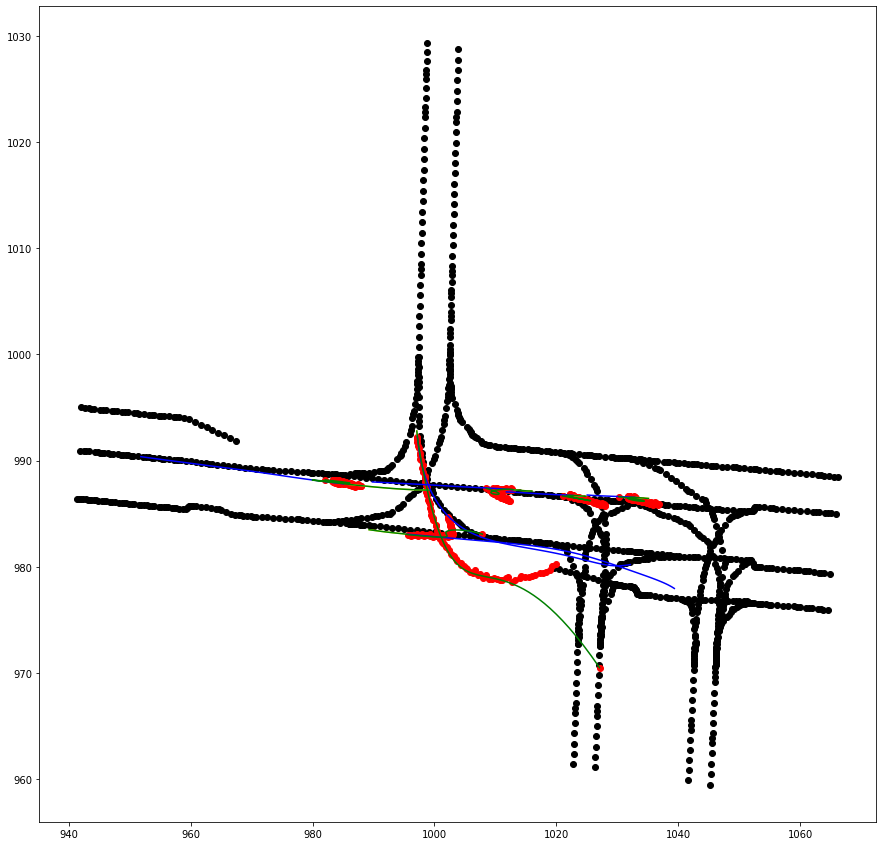

In [194]:
fig,ax=plt.subplots(1,1, figsize=(15,15))
orig = origin_data['orig']
rot = origin_data['rot']

centerline = origin_data['graph']['ctrs']
centerline = np.matmul(rot.T, (centerline.reshape(-1, 2)).T).T
centerline = np.array([centerline[:, 0] + orig[0], centerline[:, 1] + orig[1]]).T

ax.scatter(centerline[:,0], centerline[:,1], color='black')

for a in range(len(origin_data['agt_ids'])): #每个文件仅有ego(AGENT)有预测.所以多个a需要多个densefile
    other_id = origin_data['agt_ids'][a]
    if str(other_id) not in pred_trajs_all[track_id][start_time]:
        print("other_id", other_id, "not in pred_trajs_all")
        continue

    dense_filename = track_id + '_' + start_time + '_' + end_time + '_' + str(other_id) + 'P0.pkl'
    with open(os.path.join(dense_path, dense_filename), 'rb') as f:
        dense_data = pickle.load(f, encoding="latin1")
        
    gt_traj = np.array(dense_data['gt_yaws']['AGENT'])

    ax.plot(gt_traj[:20,0], gt_traj[:20,1], color='yellow')
    ax.plot(gt_traj[20:,0], gt_traj[20:,1], color='blue')

    ddd = pred_trajs_all[track_id][start_time][str(other_id)][0]
    ax.scatter(ddd[:,0], ddd[:,1], color='red')

    pred_traj = np.insert(ddd, 2, values=None, axis=1)
    fttraj = np.concatenate([gt_traj[:20], pred_traj], axis=0)
    traj_xyphi, traj_interval_vel = interval_traj(fttraj)
    ax.plot(traj_xyphi[:,0], traj_xyphi[:,1], color='green')


In [348]:
# gt_traj[:20]

In [349]:
# ddd

In [ ]:
cnt = 0
for i in range(len(max_acc_rcd)):
    if max_acc_rcd[i] > 4.0 or min_acc_rcd[i] < -4.0:
        cnt+=1
cnt

In [ ]:
np.array(new_data['others_track'][other_id][1:])[:,1:]

In [115]:
collision_trajs_count = int(collision_trajs_count)

In [29]:
# print("testing_record_filename")
print("RMSE:", RMSE / total_count)
print("MASD:", MASD / total_count)
# print("Wass-Dis between gt:", scipy.stats.wasserstein_distance(gt_all_beta_rcd, all_beta_rcd))
print("My KL:", KL(gt_all_beta_rcd, all_beta_rcd))

AF = 0
AF_acc, AF_beta = 0, 0
for i in range(len(max_acc_rcd)):
    if max_acc_rcd[i] > 4.0 or min_acc_rcd[i] < -4.0 or max_beta_rcd[i] > 3.0:
        AF += 1
    if max_acc_rcd[i] > 4.0 or min_acc_rcd[i] < -4.0:
        AF_acc += 1
    if max_beta_rcd[i] >= 3.0:
        AF_beta += 1
# print("AF:", AF)
print("超加速度", AF_acc, ", 旋转", AF_beta, "出界", off_road_count, ", AF=", AF_acc, '/', total_count, '=', AF_acc/total_count)
print("ASD:", ASD_sum / total_count)
print("FSD:", FSD_sum / total_count)
print("collision=", collision_trajs_count, '/', total_count, '=', collision_trajs_count/total_count)


RMSE: 8.104734445763134
MASD: 6.132952097952313
My KL: 0.9709136974267284
超加速度 1762 , 旋转 105 出界 125 , AF= 1762 / 2849 = 0.6184626184626184
ASD: 0.6406133449966905
FSD: 2.1302624442867746
collision= 574.0 / 2849 = 0.20147420147420148


In [182]:
# densetnt fake

dense_path = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_densetnt_origin10s_10scsv/test_fake233/'

with open('/home/user/Backup/DRL服务器备份/Projects/DenseTNT/pred_trajs_fake233_80', 'rb') as f:
    pred_trajs_fake = pickle.load(f, encoding="latin1")

test_rcd_path = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/reactivity_tracks/'


# begin inference
preds = {}
gts = {}
cities = {}

data_list = []
off_road_count = 0
total_count = 0
ASD_sum, FSD_sum = 0, 0
k = 0

max_acc_rcd, min_acc_rcd = [], []
all_beta_rcd, max_beta_rcd = [], []
gt_all_beta_rcd = []

use_ground_truth = False #首次启动为True
use_raw_pred = False #默认False

MASD = 0
RMSE = 0
rearidx = [0,1,4,2,3]

AF_acc, AF_beta, Col = 0, 0, 0
fake_collision_trajs_count = 0
fake_first_collision_trajs_count = 0

# def yaw_diff(cur_yaw, last_yaw):
#     return min((cur_yaw - last_yaw) % 6.28, (last_yaw - cur_yaw) % 6.28)

def yaw_diff(cur_yaw, last_yaw):
    yaw_diff = cur_yaw - last_yaw
    if yaw_diff > 3.14:
        yaw_diff = 6.28 - yaw_diff
    elif yaw_diff < -3.14:
        yaw_diff = 6.28 + yaw_diff
        
    return yaw_diff


count = 0
for filename in os.listdir(dense_path):
    count += 1
#     print(count, filename)
    if filename[-6:-4] == "P0":
        use_img = img_EP0
        min_x, max_x, min_y, max_y = EP0_bds
    elif filename[-6:-4] == "P1":
        use_img = img_EP1    
        min_x, max_x, min_y, max_y = EP1_bds
    elif filename[-6:-4] == "GL":
        use_img = img_GL
        min_x, max_x, min_y, max_y = GL_bds
    else:
        use_img = img_MA
        min_x, max_x, min_y, max_y = MA_bds


    with open(os.path.join(dense_path, filename), 'rb') as f:
        dense_data = pickle.load(f, encoding="latin1")
    with open(os.path.join(test_rcd_path, filename), 'rb') as f:
        test_rcd_data = pickle.load(f, encoding="latin1")

    pk_name = filename.split('/')[-1][:-6]
    track_id, start_time, end_time, ego_id = pk_name.split('_')
    
    ego_id = int(ego_id)

    col_test_trajectorys = []

    in_road_trajectories = []
    ASDs, FSDs = [], []
    for k in range(1):
#         gt_xy = np.array(dense_data['id2info']['AGENT'])[:,3:5].astype(float)
#         gt_phi= np.array(dense_data['gt_yaws']['AGENT']).reshape(100, 1)
#         gt_hist = np.concatenate([gt_xy, gt_phi], axis=1)
        gt_hist = np.array(dense_data['gt_yaws']['AGENT'])[:,[1,2,5]]
        pred_traj = np.insert(pred_trajs_fake[track_id][start_time][str(ego_id)][k], 2, values=None, axis=1)

        fttraj = np.concatenate([gt_hist[:20], pred_traj], axis=0)
        traj_xyphi, traj_interval_vel = interval_traj(fttraj)
        if k == 0:

            flag_off_road = False
            for ttt in range(traj_xyphi.shape[0]):
                x, y = traj_xyphi[ttt][:2]

                # 正常行驶至道路末端
                if x < min_x or x > max_x or y < min_y or y > max_y:
                    print("out of map")
                    continue

                grid_x, grid_y = int((x - min_x) / (max_x - min_x + 1) * use_img.shape[1]), int((max_y - y) / (max_y - min_y + 1) * use_img.shape[0])
                if use_img[grid_y, grid_x] != 0:
#                         print("tag from %s agt %d fail at time %d, pos %f, %f, value %d" %(tag, a, ttt, x, y, use_img[grid_y, grid_x]))
                    flag_off_road = True

            if flag_off_road:
                off_road_count += 1
                print("flag off road", off_road_count)
                continue

            in_road_trajectories.append(traj_xyphi)
            col_test_trajectorys.append(traj_xyphi)

        N = len(col_test_trajectorys)
        collision = np.zeros(N+1)
        fake_hist = np.array(dense_data['gt_yaws']['AV'])[:,[1,2,5]]
        
        assert np.all(fake_hist==fake_hist[::-1])
        
        for time_stamp in range(100):
            polygon_coll = []
            ms_ego = np.zeros([3])
            ms_ego[0] = col_test_trajectorys[0][time_stamp][0]
            ms_ego[1] = col_test_trajectorys[0][time_stamp][1]
            ms_ego[2] = col_test_trajectorys[0][time_stamp][2]

            width = test_rcd_data['others_track'][ego_id][0][0]
            length = test_rcd_data['others_track'][ego_id][0][1]

            p1 = Polygon(polygon_xy_from_motionstate(ms_ego, width, length))

            
            ms_fake = np.zeros([3])
            ms_fake[0] = fake_hist[0,0]
            ms_fake[1] = fake_hist[0,1]
            ms_fake[2] = fake_hist[0,2]
            
            
            for other_id in test_rcd_data['others_track'].keys():
                if other_id != ego_id:
                    break
            width = test_rcd_data['others_track'][other_id][0][0]
            length = test_rcd_data['others_track'][other_id][0][1]

            p2 = Polygon(polygon_xy_from_motionstate(ms_fake, width, length))
            
            if(p1.intersects(p2)):
                collision[0] = 1
                collision[1] = 1
        fake_collision_trajs_count += np.sum(collision)
#         if k == 0:
#             fake_first_collision_trajs_count += np.sum(collision)

print(fake_collision_trajs_count)
print(count * 2)

flag off road 1
flag off road 2
flag off road 3
flag off road 4
flag off road 5
flag off road 6
flag off road 7
flag off road 8
flag off road 9
242.0
466


In [183]:
fake_collision_trajs_count / 2 / 233

0.51931330472103

In [123]:
off_road_count

9

In [ ]:
# prediction
tmp_N = 40
tmp = np.zeros(tmp_N + 1)
itv = (max(all_beta_rcd) - min(all_beta_rcd)) / tmp_N

bb = min(all_beta_rcd)
for beta in all_beta_rcd :
    tmp[int((beta - bb) // itv)] += 1
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)],  (tmp / len(all_beta_rcd)), width=2/tmp_N)

mean_beta = sum(all_beta_rcd) / len(all_beta_rcd)
print("raw routeloss all beta")
# np.sum((np.array(all_beta_rcd) - mean_beta) ** 2) / len(all_beta_rcd)

In [ ]:

tmp = np.zeros(tmp_N + 1)
itv = (max(max_beta_rcd) - min(max_beta_rcd)) / tmp_N

bb = min(max_beta_rcd)
for beta in max_beta_rcd :
    tmp[int((beta - bb) // itv)] += 1
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)], tmp / len(max_beta_rcd), width=2/tmp_N)

mean_beta = sum(max_beta_rcd) / len(max_beta_rcd)
print("routeloss max beta")

In [ ]:
fig, ax = plt.subplots(1,1,figsize = [10,6])
tmp_N = 40 
tmp = np.zeros(tmp_N * 2 + 2)
itv = max(max(max_acc_rcd), -min(min_acc_rcd)) / tmp_N

for acc in min_acc_rcd :
    tmp[tmp_N - int(abs(acc) // itv)] += 1
    
for acc in max_acc_rcd :
    tmp[tmp_N + int(acc // itv)] += 1
    
font2 = {'family':'Times New Roman',
'size' : 25,
}
plt.tick_params(labelsize=25)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
    
plt.bar([(i - 40 + 0.5) * itv for i in range(tmp_N * 2 + 2)], 100 * tmp / len(max_acc_rcd), width=3.9/tmp_N)
plt.xlabel("Max acceleration m/s^2", font2)
plt.ylabel("Probability %", font2)
plt.savefig('/home/user/Logs/1102/acc', dpi=400)
# plt.title("acceleration distribution ", font2)

In [ ]:
max_acc_rcd

In [ ]:
print(len(max_acc_rcd))
print(np.sum(np.array(max_acc_rcd) > 4.0))

In [ ]:
print(off_road_count)
print(total_count)
print(1.0 * off_road_count / total_count)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
idx = 0
thrd = 2


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    



gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]

filename = data['filename'][idx].split('/')[-1]
for k in range(1):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()

#     plt.gca().invert_yaxis()     

    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')
    for a in range(origin_data['shapes'].shape[0]):
        other_id = origin_data['agt_ids'][a]
        #####
        if filename not in testing_record or other_id not in testing_record[filename]:
            print("nonexist")
            continue
        
        
        with open(os.path.join(filepath, filename), 'rb') as f:
            origin_data = pickle.load(f, encoding="latin1")
#         other_id = origin_data['agt_ids'][a]

        if other_id not in testing_record[filename]:
            continue
        traj_RL = np.array(testing_record[filename][other_id]['trajectory'])

        
        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        hist = data['feats'][idx][a]
#         plt.plot(hist[:, 0], hist[:, 1], 'y.')
        for l in data['ref_paths'][idx][a]:
            lane = torch.matmul(l - data['orig'][idx], rot.T)
#             plt.plot(lane[:, 0], lane[:, 1], 'g')
#         traj_plot(gt_pred,  rot, orig, ax, 'r.')

        pred_traj = results[idx][a, k, :, :]
#         for i in range(1, pred_traj.shape[0]):
#             if dis(pred_traj[i][0], pred_traj[i - 1][0], pred_traj[i][1], pred_traj[i - 1][1]) < thrd:
#                 results[idx][a, k][i] = results[idx][a, k][i - 1]
#         traj_plot(pred_traj, rot, orig, ax, 'b.')
        print(output['cls'][idx][a][k])
        
        
        traj = torch.matmul(output['reg'][idx][a][k].cpu() - data['orig'][idx], rot.T)
        diff = traj[1:] - traj[:-1]
#         S_pred = torch.sum(torch.sqrt(torch.sum(diff ** 2, axis=1)))

        lane_pts = torch.matmul(output['lane_pts'][idx][a][k].cpu() - data['orig'][idx], rot.T)

#         min_final_dis = float('inf')
#         min_final_lane = None
#         min_final_pt = None
#         for ref in data['ref_paths'][idx][a]:
#             if ref is None:
#                 continue
            
#             Lane = torch.matmul(ref - data['orig'][idx], rot.T)
#             map_car0 = Lane - traj[-1]
#             lane_end_id = torch.argmin(torch.sum(map_car0 ** 2, 1))

#             final_pt = Lane[lane_end_id]
        
#             final_dis = torch.sqrt(torch.sum((final_pt - traj[-1]) ** 2))
#             if min_final_dis > final_dis:
#                 min_final_dis = final_dis
#                 min_final_lane = Lane
#                 min_final_pt = final_pt
            
        
        traj_plot(gt_pred,  rot, orig, ax, 'r.')
        traj_plot(pred_traj, rot, orig, ax, 'b.')
        traj_plot(traj_RL,  rot, orig, ax, 'y.')
#         plt.plot(hist[:, 0], hist[:, 1], 'y.')
            
        
#         plt.scatter(min_final_pt[0], min_final_pt[1], s=150)
        plt.scatter(lane_pts[:,0], lane_pts[:,1], s=150)
        
#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Logs/0826/' + str(idx) + '_' + str(k))
    plt.show()

    

In [ ]:
for idx in range(len(data['filename'])):
    filename = data['filename'][idx].split('/')[-1]
    if filename in testing_record:
        print(idx)
        

In [ ]:
# filename = data['filename'][1].split('/')[-1]
# testing_record[filename].keys()

# origin_data['agt_ids']
len(testing_record.keys())
testing_record['5_66300_76300_39P0.pkl']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
idx = 7
thrd = 2


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    



gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]
for k in range(6):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     

    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')
    
    filename = data['filename'][idx].split('/')[-1]
    ego_id = int(filename.split('_')[-1][:-6])
    
    with open(os.path.join(origin_path, filename), 'rb') as f:
        origin_data = pickle.load(f, encoding="latin1")
    
    for a in range(len(origin_data['agt_ids'])):
        other_id = origin_data['agt_ids'][a]
        if other_id != ego_id:
            continue

        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        hist = data['feats'][idx][a]

#         traj_to_show, traj_interval_vel = interval(data, results, idx, a, k)
#         sp = spline5(Xseq=traj_interval_vel[:, 0], 
#                      Yseq=traj_interval_vel[:, 1])
# #                      vx=np.cos(traj_interval_vel[:,2]) * traj_interval_vel[:,3] / 10, 
# #                      vy=np.sin(traj_interval_vel[:,2]) * traj_interval_vel[:,3] / 10)
        
#         X, Y, VX, VY = [], [], [], []
#         for t in range(100):
#             x, y, dx, dy = sp.cal(t/99)
#             X.append(x)
#             Y.append(y)
#             VX.append(dx)
#             VY.append(dy)
            

#         lane_pts = torch.matmul(output['lane_pts'][idx][a][k].cpu() - data['orig'][idx], rot.T)
#         plt.plot(lane_pts[:, 0], lane_pts[:, 1], 'g-')

        
        plt.plot(hist[:, 0], hist[:, 1], 'y.')
        traj_plot(gt_preds[a],  rot, orig, ax, 'r.')
#         traj_plot(traj_to_show, rot, orig, ax, 'g.')
        
#         pred_traj = np.insert(results[idx][a, k, :, :], 2, values=None, axis=1)
#         traj_plot(traj_interval_vel, rot, orig, ax, 'b.')
        
        pred_traj = np.insert(pred_trajs[filename][k], 2, values=None, axis=1)

        fttraj = np.concatenate([data['gt_hist'][idx][a].numpy(), pred_traj], axis=0)
        traj_xyphi, traj_interval_vel = interval_traj(fttraj.copy())

        traj_plot(traj_xyphi, rot, orig, ax, 'g')
        
#         plt.scatter(lane_pts[:,0], lane_pts[:,1], s=150)
        
#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Logs/0826/' + str(idx) + '_' + str(k))
    plt.show()


In [ ]:
origin_data

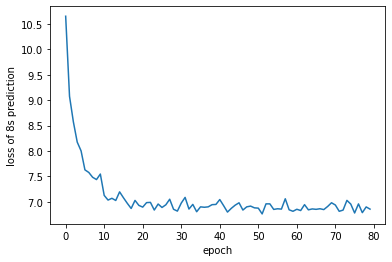

In [253]:
train_loss_10s = []
with open("/home/user/Backup/DRL服务器备份/Projects/DenseTNT/models_10s_all_output_loss.densetnt.1/train_loss", 'r') as inFile:#以只读方式打开某filename文件
    #定义2个空的list，用来存放文件中的数据
    sum_xy = []

    for line in inFile:
        if line == '\n':
            continue
        loss = float(line.split("loss: ")[-1])
        train_loss_10s.append(loss)
#         print(loss)


# plt.tick_params(labelsize=25)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

font2 = {'family':'Times New Roman',
# 'size' : 10,
}
plt.plot(train_loss_10s)
plt.xlabel("epoch", font2)
plt.ylabel("loss of 8s prediction", font2)
plt.savefig('/home/user/Backup/DRL服务器备份/Logs/1813/loss10s.png', dpi=400)

# import seaborn as sns

# sns.lineplot(x=list(range(len(train_loss_10s))), y=train_loss_10s, marker='+', label='Distribution Dots', truncate=False, line_kws={'label': 'Regression Line'})
# sns.lineplot(x=list(range(len(train_loss_10s))), y=train_loss_10s)




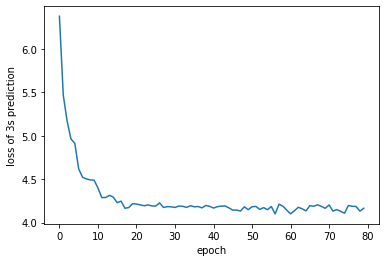

In [254]:
train_loss_5s = []
with open("/home/user/Backup/DRL服务器备份/Projects/DenseTNT/models_5s_all_output_loss.densetnt.1/train_loss", 'r') as inFile:#以只读方式打开某filename文件
    #定义2个空的list，用来存放文件中的数据
    sum_xy = []

    for line in inFile:
        if line == '\n':
            continue
        loss = float(line.split("loss: ")[-1])
        train_loss_5s.append(loss)
#         print(loss)
# plt.tick_params(labelsize=25)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

font2 = {'family':'Times New Roman',
# 'size' : 10,
}
plt.plot(train_loss_5s)
plt.xlabel("epoch", font2)
plt.ylabel("loss of 3s prediction", font2)
plt.savefig('/home/user/Backup/DRL服务器备份/Logs/1813/loss5s.png', dpi=400)

In [310]:
def get_ade(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """Compute Average Displacement Error.

    Args:
        forecasted_trajectory: Predicted trajectory with shape (pred_len x 2)
        gt_trajectory: Ground truth trajectory with shape (pred_len x 2)

    Returns:
        ade: Average Displacement Error

    """
    pred_len = forecasted_trajectory.shape[0]
    ade = float(
        sum(
            math.sqrt(
                (forecasted_trajectory[i, 0] - gt_trajectory[i, 0]) ** 2
                + (forecasted_trajectory[i, 1] - gt_trajectory[i, 1]) ** 2
            )
            for i in range(pred_len)
        )
        / pred_len
    )
    return ade


def get_fde(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """Compute Final Displacement Error.

    Args:
        forecasted_trajectory: Predicted trajectory with shape (pred_len x 2)
        gt_trajectory: Ground truth trajectory with shape (pred_len x 2)

    Returns:
        fde: Final Displacement Error

    """
    fde = math.sqrt(
        (forecasted_trajectory[-1, 0] - gt_trajectory[-1, 0]) ** 2
        + (forecasted_trajectory[-1, 1] - gt_trajectory[-1, 1]) ** 2
    )
    return fde

In [318]:
# densetnt ADE/FDE/OR
########################
config['pred_size'] = 80
dense_path = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_densetnt_origin10s_10scsv/test_yaw_others_xyphi/'
with open('/home/user/Backup/DRL服务器备份/Projects/DenseTNT/pred_trajs_for_OR_10s', 'rb') as f:
    pred_trajs_csv = pickle.load(f, encoding="latin1")
#########################
##    
off_road_count = 0
total_count = 0

AF_acc, AF_beta, Col = 0, 0, 0
min_ade_list, min_fde_list = [], []
mean_ade_list, mean_fde_list = [], []

for filename in os.listdir(dense_path):
    total_count += 1
#     print(count, filename)
    if filename[-6:-4] == "P0":
        use_img = img_EP0
        min_x, max_x, min_y, max_y = EP0_bds
    elif filename[-6:-4] == "P1":
        use_img = img_EP1    
        min_x, max_x, min_y, max_y = EP1_bds
    elif filename[-6:-4] == "GL":
        use_img = img_GL
        min_x, max_x, min_y, max_y = GL_bds
    else:
        use_img = img_MA
        min_x, max_x, min_y, max_y = MA_bds


    with open(os.path.join(dense_path, filename), 'rb') as f:
        dense_data = pickle.load(f, encoding="latin1")
#     with open(os.path.join(test_rcd_path, filename), 'rb') as f:
#         test_rcd_data = pickle.load(f, encoding="latin1")
    gt_hist = np.array(dense_data['gt_yaws']['AGENT'])

    pk_name = filename.split('/')[-1][:-6]
    track_id, start_time, end_time, ego_id = pk_name.split('_')
    
    ego_id = int(ego_id)

    mf, ma = float('inf'), float('inf')
    for k in range(6):
        pred_traj = np.insert(pred_trajs_csv[track_id][start_time][str(ego_id)][k], 2, values=None, axis=1)

        fttraj = np.concatenate([gt_hist[:20], pred_traj], axis=0)
        traj_xyphi, traj_interval_vel = interval_traj(fttraj)
#         traj_xyphi = fttraj
        
#         cur_ade = traj_diff(traj_xyphi, gt_hist)
#         cur_fde = np.sqrt(np.sum((traj_xyphi[-1][:2] - gt_hist[-1][:2]) ** 2))
        cur_ade = get_ade(traj_xyphi, gt_hist)
        cur_fde = get_fde(traj_xyphi, gt_hist)
        
        mean_ade_list.append(cur_ade)
        mean_fde_list.append(cur_fde)
        
        if cur_fde < mf:
            mf = cur_fde
            ma = cur_ade
            
        flag_off_road = False
        for ttt in range(traj_xyphi.shape[0]):
            x, y = traj_xyphi[ttt][:2]

            # 正常行驶至道路末端
            if x < min_x or x > max_x or y < min_y or y > max_y:
                print("out of map")
                continue

            grid_x, grid_y = int((x - min_x) / (max_x - min_x + 1) * use_img.shape[1]), int((max_y - y) / (max_y - min_y + 1) * use_img.shape[0])
            if use_img[grid_y, grid_x] != 0:
                flag_off_road = True

        if flag_off_road:
            off_road_count += 1
            print("flag off road", off_road_count)

    min_ade_list.append(ma)
    min_fde_list.append(mf)
            
print("预测8s ")
print("mean_ade", np.average(mean_ade_list))
print("mean_fde", np.average(mean_fde_list))
print("min_ade", np.average(min_ade_list))
print("min_fde", np.average(min_fde_list))
print("OR", off_road_count / total_count / 6)                 

flag off road 1
flag off road 2
flag off road 3
flag off road 4
flag off road 5
flag off road 6
flag off road 7
flag off road 8
flag off road 9
flag off road 10
flag off road 11
flag off road 12
flag off road 13
flag off road 14
flag off road 15
flag off road 16
flag off road 17
flag off road 18
flag off road 19
flag off road 20
flag off road 21
flag off road 22
flag off road 23
flag off road 24
flag off road 25
flag off road 26
flag off road 27
flag off road 28
flag off road 29
flag off road 30
flag off road 31
flag off road 32
flag off road 33
flag off road 34
flag off road 35
flag off road 36
flag off road 37
flag off road 38
flag off road 39
flag off road 40
flag off road 41
flag off road 42
flag off road 43
flag off road 44
flag off road 45
flag off road 46
flag off road 47
flag off road 48
flag off road 49
flag off road 50
flag off road 51
flag off road 52
flag off road 53
flag off road 54
flag off road 55
flag off road 56
flag off road 57
flag off road 58
flag off road 59
flag o

flag off road 463
flag off road 464
flag off road 465
flag off road 466
flag off road 467
flag off road 468
flag off road 469
flag off road 470
flag off road 471
flag off road 472
flag off road 473
flag off road 474
flag off road 475
flag off road 476
flag off road 477
flag off road 478
flag off road 479
flag off road 480
flag off road 481
flag off road 482
flag off road 483
flag off road 484
flag off road 485
flag off road 486
flag off road 487
flag off road 488
flag off road 489
flag off road 490
flag off road 491
flag off road 492
flag off road 493
flag off road 494
flag off road 495
flag off road 496
flag off road 497
flag off road 498
flag off road 499
flag off road 500
flag off road 501
flag off road 502
flag off road 503
flag off road 504
flag off road 505
flag off road 506
flag off road 507
flag off road 508
flag off road 509
flag off road 510
flag off road 511
flag off road 512
flag off road 513
flag off road 514
flag off road 515
flag off road 516
flag off road 517
flag off r

In [316]:
print("预测8s ")
print("mean_ade", np.average(mean_ade_list))
print("mean_fde", np.average(mean_fde_list))
print("min_ade", np.average(min_ade_list))
print("min_fde", np.average(min_fde_list))
print("OR", off_road_count / total_count)                   
        

预测8s 
mean_ade 5.384047646858681
mean_fde 13.463590083190063
min_ade 3.401656042369834
min_fde 6.816152369639226
OR 0.3269668030923147
